In [1]:
%load_ext autoreload
%autoreload 2
# Sanity check on implementation of 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import time
# Set a limit on the memory usage of the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-04-08 10:13:06.151650: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 10:13:06.151693: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 10:13:06.151721: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 10:13:06.160623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import tensorflow as tf
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cholesky

cov_dense = tf.random
# Assume you have a dense covariance matrix 'cov_dense' (tf.Tensor)
n = cov_dense.shape[0]

# Try to convert to a sparse representation (example with thresholding)
threshold = 1e-6
sparse_indices = tf.where(tf.abs(cov_dense) > threshold)
sparse_values = tf.gather_nd(cov_dense, sparse_indices)
sparse_shape = cov_dense.shape
cov_sparse_tf = tf.sparse.SparseTensor(sparse_indices, sparse_values, sparse_shape)

# Convert to SciPy sparse matrix for operations not directly in TensorFlow
cov_sparse_np = csr_matrix(cov_sparse_tf.numpy())

# Attempt sparse Cholesky (using SciPy) - needs to be wrapped in tf.py_function for TensorFlow integration
def sparse_cholesky_np(sparse_matrix):
    try:
        return cholesky(sparse_matrix, lower=True).toarray()
    except Exception as e:
        print(f"Sparse Cholesky failed: {e}")
        return np.full_like(sparse_matrix.toarray(), np.nan) # Handle potential errors

sparse_cholesky_tf = tf.py_function(
    func=sparse_cholesky_np,
    inp=[cov_sparse_np],
    Tout=tf.float32
)

# ... (rest of your log probability calculation using the sparse Cholesky factor)

# Ensure that log prob calculations are the same as tfp implementation & faster

In [ ]:
# Define your array (as a TensorFlow tensor)
n_rows = 10000 # i.e., number of voxels 
n_cols = 200 # i.e., number of samples in timeseries
num_iterations = 1000
data = tf.constant(np.random.rand(n_rows, n_cols), dtype=tf.float32)
scale_values = tf.constant(np.random.rand(n_rows, 1), dtype=tf.float32)
dof_values = tf.constant(np.random.rand(n_rows, 1), dtype=tf.float32)

#### testing calculate_log_prob_gauss_loc0

In [ ]:


# from braincoder.utils.math import calculate_log_prob_gauss_loc0
# for device in ['GPU', 'CPU']:
#     print(f'Trying with {device}')
#     with tf.device(f'/{device}:0'):
#         # Timing the custom log probability calculation
#         calculate_log_prob_gauss_loc0(data, scale_values) # Compile / warm up first
#         start_time = time.time()
#         for _ in range(num_iterations):
#             calculate_log_prob_gauss_loc0(data, scale_values)  # Now correctly broadcasted
#         time_custom = time.time() - start_time
#         output_custom = calculate_log_prob_gauss_loc0(data, scale_values)
#         # Timing the TFP log probability calculation
#         start_time = time.time()
#         for _ in range(num_iterations):
#             normal_dist = tfp.distributions.Normal(loc=0.0, scale=scale_values)  # Correct shape
#             normal_dist.log_prob(data)  # Correct shape
#         time_tfd = time.time() - start_time
#         output_tfd = normal_dist.log_prob(data)
#         # Print the results
#         print(f"Custom log probability calculation time over {num_iterations} iterations: {time_custom:.6f} seconds")
#         print(f"TFP log probability calculation time over {num_iterations} iterations: {time_tfd:.6f} seconds")
#         print(f"Custom method is  {time_tfd/time_custom:.3f} x faster")
#         print(f"     tfd,        custom")
#         for i1 in range(3):
#             for i2 in range(3):
#                 print(f'{output_tfd[i1,i2]:10.3f}, {output_custom[i1,i2]:10.3f}')


#### Testing calculate_log_prob_t

In [ ]:
# from braincoder.utils.math import calculate_log_prob_t
# for device in ['GPU', 'CPU']:
#     print(f'Trying with {device}')
#     with tf.device(f'/{device}:0'):
#         # Timing the custom log probability calculation
#         calculate_log_prob_t(data, scale_values, dof_values) # warm up first
#         start_time = time.time()
#         for _ in range(num_iterations):
#             calculate_log_prob_t(data, scale_values, dof_values)  # Now correctly broadcasted
#         time_custom = time.time() - start_time
#         output_custom = calculate_log_prob_t(data, scale_values, dof_values)

#         # Timing the TFP log probability calculation
#         start_time = time.time()
#         for _ in range(num_iterations):
#             t_dist = tfp.distributions.StudentT(df=dof_values, loc=0.0, scale=scale_values)  # Correct shape
#             t_dist.log_prob(data)  # Correct shape
#         time_tfd = time.time() - start_time
#         output_tfd = t_dist.log_prob(data)

#         # Print the results
#         print(f"Custom log probability calculation time over {num_iterations} iterations: {time_custom:.6f} seconds")
#         print(f"TFP log probability calculation time over {num_iterations} iterations: {time_tfd:.6f} seconds")
#         print(f"Custom method is  {time_tfd/time_custom:.3f} x faster")
#         print(f"     tfd,        custom")
#         for i1 in range(3):
#             for i2 in range(3):
#                 print(f'{output_tfd[i1,i2]:10.3f}, {output_custom[i1,i2]:10.3f}')


# Check GP dists

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
# Force CPU
tf.config.set_visible_devices([], 'GPU')
import math
import time
import numpy as np

from braincoder.bprf_mcmc import GPdists, mds_embedding, compute_euclidean_distance_matrix
tfd = tfp.distributions

for device in ['CPU']: #, 'GPU']:
    print(f'\n\n\n\n\nTrying with {device}')
    with tf.device(f'/{device}:0'):
        # Create a dummy symmetric distance matrix.
        n_vx = 500
        rand = tf.random.uniform((n_vx, n_vx), minval=0, maxval=1, dtype=tf.float64)
        dists = (rand + tf.transpose(rand)) / 2.0
        dists = dists - tf.linalg.diag(tf.linalg.diag_part(dists))

        # Set hyperparameters.
        gp_variance = tf.constant(1.0, dtype=tf.float32)
        gp_lengthscale = tf.constant(1.0, dtype=tf.float32)
        gp_mean = tf.constant(0.0, dtype=tf.float32)
        gp_nugget = tf.constant(0.1, dtype=tf.float32)

        # Instantiate GPdists with fixed hyperparameters.
        gp_fixed = GPdists(
            dists,
            fixed_params='fixed_all',
            full_norm=True, 
            gp_variance=gp_variance,
            gp_lengthscale=gp_lengthscale,
            gp_mean=gp_mean,
            gp_nugget=gp_nugget,
            psd_control='euclidean',
            dists_dtype=tf.float64, # for cholesky... 
            kernel='RBF',
        )

        # For comparison, get the covariance matrix computed by GPdists.
        cov_matrix = gp_fixed.cov_matrix

        # Create a random parameter vector (matching the number of vertices).
        parameter = tf.random.normal([n_vx], dtype=tf.float32)

        # Warm-up (to compile tf.function graphs)
        _ = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        _ = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)

        # Timing the fixed TF method.
        start_time = time.time()
        for _ in range(1000):  # Adjust the number of iterations as needed.
            _ = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        time_fixed_tf = time.time() - start_time

        # Timing the fixed precision method.
        start_time = time.time()
        for _ in range(1000):  # Adjust the number of iterations as needed.
            _ = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        time_fixed_prec = time.time() - start_time

        print(f"Timing for Fixed TF method: {time_fixed_tf:.6f} seconds")
        print(f"Timing for Fixed Precision method: {time_fixed_prec:.6f} seconds")
        print(f"Fixed Precision is  {time_fixed_tf/time_fixed_prec:.3f} x faster")
        # Compute log probability using the fixed TF method.
        log_prob_fixed_tf = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)

        # Compute log probability using the fixed precision method.
        log_prob_fixed_prec = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)

        print("Log probability (Fixed TF):       ", log_prob_fixed_tf.numpy())
        print("Log probability (Fixed Precision):  ", log_prob_fixed_prec.numpy())






Trying with CPU
Embedding in Euclidean space...
Precomputing covariance matrix...
Precomputing Cholesky decomposition...
Timing for Fixed TF method: 1.186564 seconds
Timing for Fixed Precision method: 6.234229 seconds
Fixed Precision is  0.190 x faster
Log probability (Fixed TF):        -2492.4941
Log probability (Fixed Precision):   -2492.4941


In [5]:
import numpy as np
import matplotlib.pyplot as plt
X = np.linspace(-10,10, 100)
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
print('GPU devices available:', tf.config.list_physical_devices('GPU'))
from braincoder.bprf_mcmc import *
dX = compute_euclidean_distance_matrix(X[...,np.newaxis])

GPU devices available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


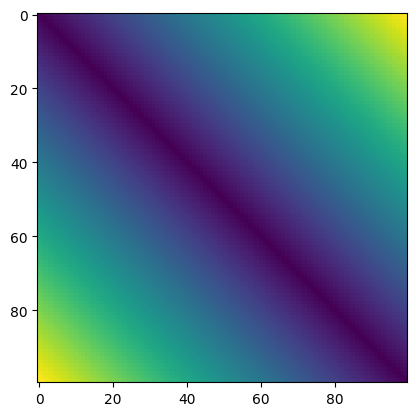

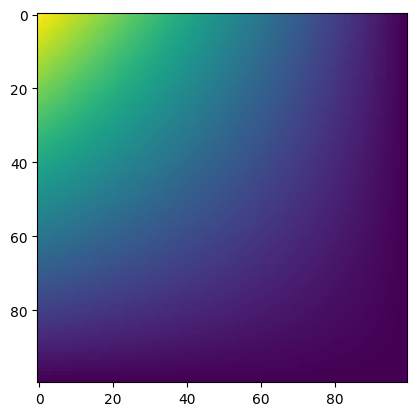

In [ ]:
plt.imshow(dX)


beep = lin_kernel(X,0.0,2.0,10.0)
plt.figure()
plt.imshow(beep)


In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import math
import time
import numpy as np

from braincoder.bprf_mcmc import GPdists, mds_embedding, compute_euclidean_distance_matrix
tfd = tfp.distributions

for device in ['GPU', 'CPU']:
    print(f'\n\n\n\n\nTrying with {device}')
    with tf.device(f'/{device}:0'):
        # Create a dummy symmetric distance matrix.
        n_vx = 500
        rand = tf.random.uniform((n_vx, n_vx), minval=0, maxval=1, dtype=tf.float64)
        dists = (rand + tf.transpose(rand)) / 2.0
        dists = dists - tf.linalg.diag(tf.linalg.diag_part(dists))

        # Set hyperparameters.
        gp_variance = tf.constant(1.0, dtype=tf.float32)
        gp_lengthscale = tf.constant(1.0, dtype=tf.float32)
        gp_mean = tf.constant(0.0, dtype=tf.float32)
        gp_nugget = tf.constant(0.1, dtype=tf.float32)

        # Instantiate GPdists with fixed hyperparameters.
        gp_fixed = GPdists(
            dists,
            fixed_params='unfixed',
            full_norm=False, 
            gp_variance=gp_variance,
            gp_lengthscale=gp_lengthscale,
            gp_mean=gp_mean,
            gp_nugget=gp_nugget,
            psd_control='euclidean',
            dists_dtype=tf.float64, # for cholesky... 
            kernel='RBF',
        )

        # For comparison, get the covariance matrix computed by GPdists.
        cov_matrix = gp_fixed.cov_matrix

        # Create a random parameter vector (matching the number of vertices).
        parameter = tf.random.normal([n_vx], dtype=tf.float32)

        # Warm-up (to compile tf.function graphs)
        _ = gp_fixed._return_log_prob_unfixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        _ = gp_fixed._return_log_prob_unfixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)

        # Timing the fixed TF method.
        start_time = time.time()
        for _ in range(1000):  # Adjust the number of iterations as needed.
            _ = gp_fixed._return_log_prob_unfixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        time_fixed_tf = time.time() - start_time

        # Timing the fixed precision method.
        start_time = time.time()
        for _ in range(1000):  # Adjust the number of iterations as needed.
            _ = gp_fixed._return_log_prob_unfixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        time_fixed_prec = time.time() - start_time

        print(f"Timing for Unfixed TF method: {time_fixed_tf:.6f} seconds")
        print(f"Timing for Unfixed Precision method: {time_fixed_prec:.6f} seconds")
        print(f"Unfixed Precision is  {time_fixed_tf/time_fixed_prec:.3f} x faster")
        # Compute log probability using the fixed TF method.
        log_prob_fixed_tf = gp_fixed._return_log_prob_unfixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)

        # Compute log probability using the fixed precision method.
        log_prob_fixed_prec = gp_fixed._return_log_prob_unfixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)

        print("Log probability (Unfixed TF):       ", log_prob_fixed_tf.numpy())
        print("Log probability (Unfixed Precision):  ", log_prob_fixed_prec.numpy())

2025-04-28 14:56:22.433371: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-28 14:56:22.433430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-28 14:56:22.433464: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 14:56:22.441904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.







Trying with GPU


2025-04-28 14:56:35.997609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10756 MB memory:  -> device: 0, name: Tesla K40m, pci bus id: 0000:03:00.0, compute capability: 3.5


Embedding in Euclidean space...


2025-04-28 14:56:37.497816: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55e7a7f7d670


Timing for Unfixed TF method: 3.113849 seconds
Timing for Unfixed Precision method: 10.321810 seconds
Unfixed Precision is  0.302 x faster
Log probability (Unfixed TF):        -2202.2886
Log probability (Unfixed Precision):   -2250.0566





Trying with CPU
Embedding in Euclidean space...


KeyboardInterrupt: 

In [ ]:
bloop

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import math
import time
import numpy as np

from braincoder.bprf_mcmc import GPdists, mds_embedding, compute_euclidean_distance_matrix
tfd = tfp.distributions
full_norm = True
# ------------------------------
# Setup: create a dummy distance matrix.
# ------------------------------
n_vx = 50
rand = tf.random.uniform((n_vx, n_vx), minval=0, maxval=1, dtype=tf.float64)
dists = (rand + tf.transpose(rand)) / 2.0
dists = dists - tf.linalg.diag(tf.linalg.diag_part(dists))

# ------------------------------
# Hyperparameters
# ------------------------------
# Note: GPdists expects the distance tensor to be tf.float64 (for Cholesky) so we set that,
# but the parameter vector itself is in tf.float32.
gp_variance = tf.constant(1.0, dtype=tf.float32)
gp_lengthscale = tf.constant(1.0, dtype=tf.float32)
gp_mean = tf.constant(0.0, dtype=tf.float32)
gp_nugget = tf.constant(0.1, dtype=tf.float32)

# ------------------------------
# Instantiate GPdists: fixed and unfixed versions.
# ------------------------------
# Fixed instance: precomputes covariance matrix, Cholesky, and precision.
gp_fixed = GPdists(
    dists,
    fixed_params=True,
    full_norm=full_norm,  # Option for full normalization in precision-based log_prob.
    gp_variance=gp_variance,
    gp_lengthscale=gp_lengthscale,
    gp_mean=gp_mean,
    gp_nugget=gp_nugget,
    psd_control='euclidean',
    dists_dtype=tf.float64,  # ensure Cholesky and covariance are computed in float64
    kernel='RBF',
    log_prob_method='precision',  # choose 'precision' for testing the new option.
)

# Unfixed instance: recomputes covariance every time.
gp_unfixed = GPdists(
    dists,
    fixed_params=False,
    full_norm=full_norm,  # will be passed to unfixed precision method
    gp_variance=gp_variance,
    gp_lengthscale=gp_lengthscale,
    gp_mean=gp_mean,
    gp_nugget=gp_nugget,
    psd_control='euclidean',
    dists_dtype=tf.float64,
    kernel='RBF',
    log_prob_method='precision',
)

# ------------------------------
# Create a random parameter vector (matches number of vertices).
# ------------------------------
parameter = tf.random.normal([n_vx], dtype=tf.float32)

# Warm-up (compile tf.function graphs)
_ = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
_ = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
_ = gp_unfixed._return_log_prob_unfixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
_ = gp_unfixed._return_log_prob_unfixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)

# ------------------------------
# Helper function to time method calls.
# ------------------------------
def time_method(method, instance, param, iterations=5000, **kwargs):
    # Warm-up one call outside timing
    _ = method(param, gp_lengthscale, gp_variance, gp_mean, gp_nugget, **kwargs)
    start = time.time()
    for _ in range(iterations):
        _ = method(param, gp_lengthscale, gp_variance, gp_mean, gp_nugget, **kwargs)
    return (time.time() - start) / iterations

# ------------------------------
# Devices to test (CPU and GPU if available)
# ------------------------------
devices = ['/cpu:0']
if tf.config.list_physical_devices('GPU'):
    devices.append('/gpu:0')

# ------------------------------
# Run tests on each device.
# ------------------------------
for device in devices:
    print("\nTesting on device:", device)
    with tf.device(device):
        # Fixed methods.
        t_fixed_tf = time_method(gp_fixed._return_log_prob_fixed_tf, gp_fixed, parameter)
        t_fixed_prec = time_method(gp_fixed._return_log_prob_fixed_prec, gp_fixed, parameter)
        
        # Unfixed methods.
        t_unfixed_tf = time_method(gp_unfixed._return_log_prob_unfixed_tf, gp_unfixed, parameter)
        t_unfixed_prec = time_method(gp_unfixed._return_log_prob_unfixed_prec, gp_unfixed, parameter)
        
        # Compute log probabilities (for a single call).
        lp_fixed_tf = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        lp_fixed_prec = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        lp_unfixed_tf = gp_unfixed._return_log_prob_unfixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        lp_unfixed_prec = gp_unfixed._return_log_prob_unfixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        
        print("Log probability (Fixed TF):        ", lp_fixed_tf.numpy())
        print("Log probability (Fixed Prec):        ", lp_fixed_prec.numpy())
        print("Log probability (Unfixed TF):        ", lp_unfixed_tf.numpy())
        print("Log probability (Unfixed Prec):      ", lp_unfixed_prec.numpy())
        
        print("\nAverage runtime per call:")
        print("  Fixed TF method:      {:.6f} sec".format(t_fixed_tf))
        print("  Fixed Precision method: {:.6f} sec".format(t_fixed_prec))
        print("  Unfixed TF method:    {:.6f} sec".format(t_unfixed_tf))
        print("  Unfixed Precision method: {:.6f} sec".format(t_unfixed_prec))


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import math
import time
import numpy as np

from braincoder.bprf_mcmc import GPdists, mds_embedding, compute_euclidean_distance_matrix
tfd = tfp.distributions
full_norm = False
# ------------------------------
# Setup: create a dummy distance matrix.
# ------------------------------
n_vx = 50
rand = tf.random.uniform((n_vx, n_vx), minval=0, maxval=1, dtype=tf.float64)
dists = (rand + tf.transpose(rand)) / 2.0
dists = dists - tf.linalg.diag(tf.linalg.diag_part(dists))

# ------------------------------
# Hyperparameters
# ------------------------------
# Note: GPdists expects the distance tensor to be tf.float64 (for Cholesky) so we set that,
# but the parameter vector itself is in tf.float32.
gp_variance = tf.constant(1.0, dtype=tf.float32)
gp_lengthscale = tf.constant(1.0, dtype=tf.float32)
gp_mean = tf.constant(0.0, dtype=tf.float32)
gp_nugget = tf.constant(0.1, dtype=tf.float32)

# ------------------------------
# Instantiate GPdists: fixed and unfixed versions.
# ------------------------------
# Fixed instance: precomputes covariance matrix, Cholesky, and precision.
gp_fixed = GPdists(
    dists,
    fixed_params=True,
    full_norm=True,  # Option for full normalization in precision-based log_prob.
    gp_variance=gp_variance,
    gp_lengthscale=gp_lengthscale,
    gp_mean=gp_mean,
    gp_nugget=gp_nugget,
    psd_control='euclidean',
    dists_dtype=tf.float64,  # ensure Cholesky and covariance are computed in float64
    kernel='RBF',
    log_prob_method='precision',  # choose 'precision' for testing the new option.
)

# Unfixed instance: recomputes covariance every time.
gp_unfixed = GPdists(
    dists,
    fixed_params=False,
    full_norm=True,  # will be passed to unfixed precision method
    gp_variance=gp_variance,
    gp_lengthscale=gp_lengthscale,
    gp_mean=gp_mean,
    gp_nugget=gp_nugget,
    psd_control='euclidean',
    dists_dtype=tf.float64,
    kernel='RBF',
    log_prob_method='precision',
)

# ------------------------------
# Create a random parameter vector (matches number of vertices).
# ------------------------------
parameter = tf.random.normal([n_vx], dtype=tf.float32)

# Warm-up (compile tf.function graphs)
_ = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
_ = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget, full_norm=True)
_ = gp_unfixed._return_log_prob_unfixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
_ = gp_unfixed._return_log_prob_unfixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget, full_norm=True)

# ------------------------------
# Helper function to time method calls.
# ------------------------------
def time_method(method, instance, param, iterations=100, **kwargs):
    # Warm-up one call outside timing
    _ = method(param, gp_lengthscale, gp_variance, gp_mean, gp_nugget, **kwargs)
    start = time.time()
    for _ in range(iterations):
        _ = method(param, gp_lengthscale, gp_variance, gp_mean, gp_nugget, **kwargs)
    return (time.time() - start) / iterations

# ------------------------------
# Devices to test (CPU and GPU if available)
# ------------------------------
devices = ['/cpu:0']
if tf.config.list_physical_devices('GPU'):
    devices.append('/gpu:0')

# ------------------------------
# Run tests on each device.
# ------------------------------
for device in devices:
    print("\nTesting on device:", device)
    with tf.device(device):
        # Fixed methods.
        t_fixed_tf = time_method(gp_fixed._return_log_prob_fixed_tf, gp_fixed, parameter)
        t_fixed_prec = time_method(gp_fixed._return_log_prob_fixed_prec, gp_fixed, parameter, full_norm=True)
        
        # Unfixed methods.
        t_unfixed_tf = time_method(gp_unfixed._return_log_prob_unfixed_tf, gp_unfixed, parameter)
        t_unfixed_prec = time_method(gp_unfixed._return_log_prob_unfixed_prec, gp_unfixed, parameter, full_norm=True)
        
        # Compute log probabilities (for a single call).
        lp_fixed_tf = gp_fixed._return_log_prob_fixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        lp_fixed_prec = gp_fixed._return_log_prob_fixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget, full_norm=True)
        lp_unfixed_tf = gp_unfixed._return_log_prob_unfixed_tf(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget)
        lp_unfixed_prec = gp_unfixed._return_log_prob_unfixed_prec(parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget, full_norm=True)
        
        print("Log probability (Fixed TF):        ", lp_fixed_tf.numpy())
        print("Log probability (Fixed Prec):        ", lp_fixed_prec.numpy())
        print("Log probability (Unfixed TF):        ", lp_unfixed_tf.numpy())
        print("Log probability (Unfixed Prec):      ", lp_unfixed_prec.numpy())
        
        print("\nAverage runtime per call:")
        print("  Fixed TF method:      {:.6f} sec".format(t_fixed_tf))
        print("  Fixed Precision method: {:.6f} sec".format(t_fixed_prec))
        print("  Unfixed TF method:    {:.6f} sec".format(t_unfixed_tf))
        print("  Unfixed Precision method: {:.6f} sec".format(t_unfixed_prec))


# bloop

In [ ]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
import tensorflow_probability as tfp
import math
import numpy as np

tfd = tfp.distributions

# Generate a random positive definite covariance matrix for a 5-dimensional Gaussian.
n = 5
# Create a random matrix and form a covariance matrix by A * A^T.
A = tf.random.normal((n, n), dtype=tf.float64)
cov = tf.matmul(A, A, transpose_b=True) + tf.eye(n, dtype=tf.float64)*1e-3
mean = tf.random.normal((n,), dtype=tf.float64)
x = tf.random.normal((n,), dtype=tf.float64)

# 1. Log probability using TFP's MultivariateNormalFullCovariance:
dist = tfd.MultivariateNormalFullCovariance(loc=mean, covariance_matrix=cov)
log_prob_tfp = dist.log_prob(x)

# 2. Log probability using the full Gaussian formula:
#    log p(x) = -0.5 * [ n*log(2π) + log|cov| + (x-mean)^T cov^-1 (x-mean) ]
def full_gaussian_log_prob(x, mean, cov):
    n = tf.cast(tf.shape(x)[0], cov.dtype)
    diff = x - mean
    inv_cov = tf.linalg.inv(cov)
    log_det_cov = tf.linalg.logdet(cov)
    quad_form = tf.tensordot(diff, tf.linalg.matvec(inv_cov, diff), axes=1)
    # Cast constant 2*pi to the same dtype as cov
    two_pi = tf.constant(2 * math.pi, dtype=cov.dtype)
    return -0.5 * (n * tf.math.log(two_pi) + log_det_cov + quad_form)

log_prob_full = full_gaussian_log_prob(x, mean, cov)

# 3. Log probability using the precision matrix directly:
#    We use the fact that:
#      log p(x) = 0.5 * log|Q| - 0.5 * (x-mean)^T Q (x-mean) - (n/2)*log(2π)
#    where Q = cov^-1.
Q = tf.linalg.inv(cov)
log_det_Q = tf.linalg.logdet(Q)
diff = x - mean
quad_form_precision = tf.tensordot(diff, tf.linalg.matvec(Q, diff), axes=1)
two_pi = tf.constant(2 * math.pi, dtype=cov.dtype)
log_prob_precision = 0.5 * log_det_Q - 0.5 * quad_form_precision - 0.5 * tf.cast(n, cov.dtype) * tf.math.log(two_pi)

print("Log probability (TFP):         ", log_prob_tfp.numpy())
print("Log probability (Full formula):", log_prob_full.numpy())
print("Log probability (Precision):   ", log_prob_precision.numpy())


# SPDE METHOD

In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.spatial.distance import pdist, squareform
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
import numpy as np
import scipy.sparse as sp
from scipy.spatial.distance import pdist, squareform
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sub = 'fsaverage'
from ncsf_bayesian.ncsf_load_saved_info import *
from dpu_mini.mesh_maker import *
gm = GenMeshMaker(sub=sub, fs_dir=ncsf_fsdir)
mask = dag_load_roi(sub, fs_dir=ncsf_fsdir, roi='lh.V1_ex')
mask_lh = mask[:gm.n_vx['lh']]
gm.make_flat_map(
    mask, morph=2,    
)
sm = dag_submesh_from_mesh(mesh_info=gm.mesh_info['pial']['lh'], submesh_bool=mask_lh)
gdists = dag_pairwise_geodesic_distance(
    gm.mesh_info['pial']['lh'], mask_lh, 
)

Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/derivatives/freesurfer
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
centering!
Faces with missing vx: 319983
Faces with long edges: 1555
0.0234893798828125
centering!


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dpu_mini/dpu_mini/mesh_format.py:400: RuntimeWarning: Mean of empty slice.
  centre_lat = lat[centre_bool].mean()
/home/daghlian/.conda/envs/bcoder005/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dpu_mini/dpu_mini/mesh_format.py:401: RuntimeWarning: Mean of empty slice.
  centre_lon = lon[centre_bool].mean()
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dpu_mini/dpu_mini/mesh_maker.py:527: RuntimeWarning: Mean of empty slice.
  flat[connected_pts] -= flat[connected_pts].mean(axis=0)
/home/daghlian/.conda/envs/bcoder005/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dpu_mini/dpu_mini/mesh_maker.py:528: RuntimeWarning: div

Faces with missing vx: 327680
Faces with long edges: 0
0.0
Missing 2 vx
If you want to be more inclusive try again with morph>0
Missing 2 vx
If you want to be more inclusive try again with morph>0
3405
Creating distance by distance matrices


Calculating geodesic distances:   0%|          | 0/3405 [00:00<?, ?it/s]/home/daghlian/.conda/envs/bcoder005/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
Calculating geodesic distances: 100%|██████████| 3405/3405 [00:08<00:00, 378.72it/s]


In [ ]:
sm['coords']

In [8]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import numpy as np
import math
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg
from braincoder.bprf_mcmc import mds_embedding, compute_euclidean_distance_matrix
# --- Utility Functions for Embedding & Distance Matrix ---
# --- Base Class: Common Data & Functions ---

class GPBase:
    def __init__(self, **kwargs):
        """
        Base class for GPdists that sets up the distance matrix and common parameters.
        
        Args:
            dists (array-like): Distance matrix.
            **kwargs: Keyword arguments that include:
                - psd_control: Either 'euclidean' (will embed to Euclidean space) or 'none'.
                - embedding_dim: Dimensionality for MDS embedding.
                - dists_dtype: TensorFlow dtype (default: tf.float64).
        """
        self.kernel = kwargs.get('kernel', 'RBF')
        self.inducer_selection = kwargs.get('inducer_selection', 'random')

        # Fixed GP hyperparameters (when fixed_params is True)
        self.fixed_params = kwargs.get('fixed_params', 'unfixed') # fixed_vl, fixed_all
        self.f_gp_variance = kwargs.get('gp_variance', None)
        self.f_gp_lengthscale = kwargs.get('gp_lengthscale', None)
        self.f_gp_mean = kwargs.get('gp_mean', 0.0)
        self.f_gp_nugget = kwargs.get('gp_nugget', 0.0)


# --- Dense (Standard) GP Class ---

class GPdistsDense(GPBase):
    def __init__(self, dists, **kwargs):
        """
        Initialize the GPdists class.
        Objective: take geodesic distances (dists) per vertex on the cortex
        Use this to construct a covariance matrix 
        which we can use as a prior for smoothness during encoding model fitting

        Args:
            dists (array-like): The input distance matrix.
            **kwargs: Optional parameters for controlling behavior, such as:
                - psd_control: Method for ensuring positive semidefiniteness.
                - dists_dtype: Data type for tensor conversion.
                - fixed_params: Fixing (some) of the GP parameters? Precomputes what is possible for efficiency
                    'unfixed'       Everything can change
                    'fixed_vl'      variance, lengthscale are fixed, others can change
                    'fixed_all'     Everything is fixed
                - gp_variance, gp_lengthscale, gp_mean, gp_nugget: GP hyperparameters.
                - kernel: Choice of covariance function (default: 'RBF').
        """
        super().__init__(**kwargs)
        self.kernel = kwargs.get('kernel', 'RBF')
        self.inducer_selection = kwargs.get('inducer_selection', 'random')

        # Setup distance matrix and positive semidefinite control
        self.psd_control   = kwargs.get('psd_control', 'euclidean')  # 'euclidean' or 'none'
        self.embedding_dim = kwargs.get('embedding_dim', 10)
        self.dists_dtype   = kwargs.get('dists_dtype', tf.float64)
        self.dists_raw = tf.convert_to_tensor(dists, dtype=self.dists_dtype)
        self.dists_raw = (self.dists_raw + tf.transpose(self.dists_raw)) / 2.0

        if self.psd_control == 'euclidean':
            print('Embedding in Euclidean space...')
            X = mds_embedding(self.dists_raw, self.embedding_dim)
            self.dists = compute_euclidean_distance_matrix(X)
        else:
            self.dists = self.dists_raw

        self.n_vx = self.dists.shape[0]

        # Precompute covariance related matrices if parameters are fixed
        if self.fixed_params == 'unfixed':
            # Nothing is fixed...
            self.cov_matrix = None
            self.prec_matrix = None
            self.chol = None
            self.gp_prior_dist = None
        elif self.fixed_params == 'fixed_all':
            print('Precomputing covariance matrix...')
            self.cov_matrix = self.return_sigma(
                gp_lengthscale=self.f_gp_lengthscale,
                gp_variance=self.f_gp_variance,
                gp_nugget=self.f_gp_nugget,
            )
            # Compute precision matrix once
            self.prec_matrix = tf.cast(tf.linalg.inv(self.cov_matrix), dtype=tf.float32)
            print('Precomputing Cholesky decomposition...')
            self.chol = tf.linalg.cholesky(tf.cast(self.cov_matrix, dtype=self.dists_dtype))
            # Create the fixed prior distribution
            self.gp_prior_dist = tfd.MultivariateNormalTriL(
                loc=tf.cast(tf.fill([self.n_vx], self.f_gp_mean), dtype=tf.float32),
                scale_tril=tf.cast(self.chol, dtype=tf.float32),
                allow_nan_stats=False,
            )
        elif self.fixed_params == 'fixed_vl':
            raise NotImplementedError("Fixed parameters with 'fixed_vl' option is not implemented yet.")
        else:
            raise ValueError(f"Invalid fixed_params option: {self.fixed_params}. Choose from 'unfixed', 'fixed_vl', or 'fixed_all'.")
        self.set_log_prob()

    @tf.function
    def return_sigma(self, gp_lengthscale, gp_variance, gp_nugget=0.0, dists=None):
        """
        Computes the covariance matrix using the chosen kernel.

        Args:
            gp_lengthscale (float): Lengthscale parameter.
            gp_variance (float): Variance parameter.
            gp_nugget (float): Nugget (noise) term.

        Returns:
            tf.Tensor: Covariance matrix.
        """
        if dists is None: 
            dists = self.dists
        gp_nugget = tf.cast(gp_nugget, dtype=self.dists_dtype)
        gp_variance = tf.cast(gp_variance, dtype=self.dists_dtype)
        gp_lengthscale = tf.cast(gp_lengthscale, dtype=self.dists_dtype)

        if self.kernel == 'RBF':
            cov_matrix = tf.square(gp_variance) * tf.exp(
                -tf.square(dists) / (2.0 * tf.square(gp_lengthscale))
            )
        elif self.kernel == 'matern52':
            sqrt5 = tf.cast(tf.sqrt(5.0), dtype=self.dists_dtype)
            frac1 = (sqrt5 * dists) / gp_lengthscale
            frac2 = (5.0 * tf.square(dists)) / (3.0 * tf.square(gp_lengthscale))
            cov_matrix = tf.square(gp_variance) * (1 + frac1 + frac2) * tf.exp(-frac1)
        elif self.kernel == 'laplace':
            cov_matrix = tf.square(gp_variance) * tf.exp(-dists / gp_lengthscale)
        else:
            raise ValueError("Unsupported kernel: {}".format(self.kernel))
        # Add nugget term for numerical stability
        return cov_matrix + tf.eye(cov_matrix.shape[0], dtype=self.dists_dtype) * (1e-6 + gp_nugget)    

    def set_log_prob(self):
        """
        Set the log probability method based on whether parameters are fixed and the chosen method.
        """
        if self.fixed_params == 'fixed_all':
            # When hyperparameters are fixed, use the precomputed distribution or precision
            self.return_log_prob = self._return_log_prob_fixed_tf
        elif self.fixed_params == 'unfixed':
            self.return_log_prob = self._return_log_prob_unfixed_tf
        else:
            raise ValueError(f"Invalid fixed_params option: {self.fixed_params}. Choose from 'unfixed', 'fixed_vl', or 'fixed_all'.")


    @tf.function
    def _return_log_prob_fixed_tf(self, parameter, gp_lengthscale, gp_variance, gp_mean=0.0, gp_nugget=0.0, n_inducers=None):
        """
        Fixed parameters using TensorFlow distribution.
        The extra hyperparameter inputs are included to maintain the gradient graph,
        even though they are not used.
        """
        # Note: The extra terms are added via tf.stop_gradient to keep gradients flowing
        extra = tf.stop_gradient(gp_lengthscale + gp_variance + gp_mean + gp_nugget) * 0.0
        return self.gp_prior_dist.log_prob(parameter) + extra

    @tf.function
    def _return_log_prob_unfixed_tf(self, parameter, gp_lengthscale, gp_variance, gp_mean=0.0, gp_nugget=0.0, n_inducers=None):
        """
        Unfixed parameters using TensorFlow distribution.
        Recompute covariance and Cholesky decomposition on the fly.
        Optionally uses random selection of n_inducers for sparse GP approximation.
        """
        if n_inducers is None or n_inducers >= self.n_vx:
            # Full GP
            cov_matrix = self.return_sigma(gp_lengthscale, gp_variance, gp_nugget)
            chol = tf.linalg.cholesky(tf.cast(cov_matrix, dtype=self.dists_dtype))

            gp_prior_dist = tfd.MultivariateNormalTriL(
                loc=tf.fill([self.n_vx], tf.squeeze(gp_mean)),
                scale_tril=tf.cast(chol, dtype=tf.float32),
                allow_nan_stats=False,
            )
            return gp_prior_dist.log_prob(parameter)
        else:
            # Sparse GP approximation using inducing points
            if n_inducers <= 0:
                raise ValueError("n_inducers must be a positive integer.")
            inducing_indices, inducing_dists = self._return_inducing_idx_and_dists(n_inducers=n_inducers)
            # Get the parameter values at the inducing points
            inducing_parameter = tf.gather(parameter, inducing_indices)

            # Calculate the covariance matrix for the inducing points
            inducing_cov_matrix = self.return_sigma(gp_lengthscale, gp_variance, gp_nugget, dists=inducing_dists)
            inducing_chol = tf.linalg.cholesky(tf.cast(inducing_cov_matrix, dtype=self.dists_dtype))

            inducing_gp_prior_dist = tfd.MultivariateNormalTriL(
                loc=tf.fill([n_inducers], tf.squeeze(gp_mean)),
                scale_tril=tf.cast(inducing_chol, dtype=tf.float32),
                allow_nan_stats=False,
            )
            return inducing_gp_prior_dist.log_prob(inducing_parameter)
    
    @tf.function
    def _return_inducing_idx_and_dists(self, n_inducers):
        if self.inducer_selection == 'random':
            # Randomly select indices for inducing points
            inducing_indices = tf.random.shuffle(tf.range(self.n_vx))[:n_inducers]
            inducing_indices = tf.sort(inducing_indices)  # Keep them sorted for easier indexing

        elif self.inducer_selection == 'close':
            centre_idx = np.random.randint(0, self.n_vx)
            # Get the indices of the closest n_inducers points
            _, inducing_indices = tf.math.top_k(-self.dists[centre_idx, :], k=n_inducers)
            inducing_indices = tf.sort(inducing_indices)  # Keep sorted

        else:
            raise ValueError(f"Unknown inducer selection method: {self.inducer_selection}")

        # Gather distances for the selected inducing points
        inducing_dists = tf.gather(tf.gather(self.dists, inducing_indices, axis=0), inducing_indices, axis=1)
        
        return inducing_indices, inducing_dists

# --- Lindgren SPDE GP Class ---

class GPLindgren(GPBase):
    def __init__(self, **kwargs):
        """
        GPdists class using the Lindgren SPDE approach (Matern 5/2).
        Requires mesh information to be provided.
        
        Keyword arguments:
            mesh_vertices, mesh_faces: Required for assembling the FEM matrices.
            gp_variance, gp_lengthscale, gp_nugget: Hyperparameters.
        """
        super().__init__(**kwargs)
        self.kernel = 'matern52_lindgren'
        print("For GPdistsLindgren, kernel must be 'matern52_lindgren'.")
        self.mesh_vertices = kwargs.get('mesh_vertices', None)
        self.n_vx = self.mesh_vertices.shape[0]
        self.mesh_faces = kwargs.get('mesh_faces', None)
        if self.mesh_vertices is None or self.mesh_faces is None:
            raise ValueError("Mesh vertices and faces must be provided for Lindgren SPDE method.")
        self.full_norm = kwargs.get('full_norm', False)
        self.fixed_params = kwargs.get('fixed_params', 'unfixed')
        # If fixed_params is used and all parameters are fixed, you could precompute.
        # Here, we leave it to the log probability function for demonstration.
        self.build_Q_base()
        self.set_log_prob()

    def set_log_prob(self):
        """
        Set the log probability method for the Lindgren method.
        """
        self.return_log_prob = self._return_log_prob_lindgren

    def build_Q_base(self):
        """
        Build a sparse precision matrix Q using a Lindgren SPDE formulation for Matern 5/2.
        In this dummy example, we use the mesh connectivity.
        """
        faces = self.mesh_faces
        row_idx = []
        col_idx = []
        values = []
        # Dummy finite element assembly: assign weights per face.
        for tri in faces:
            for i in range(3):
                for j in range(3):
                    vi, vj = tri[i], tri[j]
                    row_idx.append(vi)
                    col_idx.append(vj)
                    values.append(2.0 if vi == vj else -1.0)
        self.Q_base = sp.coo_matrix((values, (row_idx, col_idx)), shape=(self.n_vx, self.n_vx)).tocsc()

    def build_lindgren_precision_matrix(self, gp_lengthscale, gp_variance, gp_nugget):
        """
        Build a sparse precision matrix Q using a Lindgren SPDE formulation for Matern 5/2.
        """
        # Matern 5/2 SPDE: kappa = sqrt(5)/lengthscale.
        kappa = np.sqrt(5.0) / gp_lengthscale
        scaled_Q = kappa**2 * sp.eye(self.n_vx, format="csc") + self.Q_base
        # Approximate precision matrix Q = (scaled_Q)^T @ (scaled_Q).
        Q = (scaled_Q.transpose() @ scaled_Q).tocoo()
        # Scale by variance and add nugget.
        Q = Q / gp_variance + gp_nugget * sp.eye(self.n_vx, format="coo")
        return Q

    def convert_scipy_sparse_to_tf(self, Q_sparse):
        """
        Convert a SciPy sparse (COO) matrix to a TensorFlow SparseTensor.
        """
        Q_coo = Q_sparse.tocoo()
        indices = np.vstack((Q_coo.row, Q_coo.col)).T
        return tf.sparse.SparseTensor(
            indices=indices,
            values=Q_coo.data.astype(np.float32),
            dense_shape=Q_coo.shape
        )

    def _log_prob_lindgren_py(self, parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget):
        """
        Python (NumPy/Scipy) implementation of the log probability via the Lindgren method.
        This routine is wrapped via tf.py_function.
        """
        gp_lengthscale = float(gp_lengthscale)
        gp_variance = float(gp_variance)
        gp_nugget = float(gp_nugget)
        gp_mean = float(gp_mean)
        parameter = np.array(parameter)
        Q_sparse = self.build_lindgren_precision_matrix(gp_lengthscale, gp_variance, gp_nugget)
        x = (parameter - gp_mean).reshape(-1, 1)
        Q_tf = self.convert_scipy_sparse_to_tf(Q_sparse)
        Q_tf = tf.sparse.reorder(Q_tf)
        x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
        xT_Q_x = tf.squeeze(tf.matmul(tf.transpose(x_tf), tf.sparse.sparse_dense_matmul(Q_tf, x_tf))).numpy()
        Q_chol = splinalg.splu(Q_sparse)
        log_det_Q = np.sum(np.log(np.abs(Q_chol.U.diagonal())))
        n = x.shape[0]
        log_prob = -0.5 * xT_Q_x + 0.5 * log_det_Q - 0.5 * n * math.log(2 * math.pi)
        return np.array(log_prob, dtype=np.float32)

    def _return_log_prob_lindgren(self, parameter, gp_lengthscale, gp_variance, gp_mean=0.0, gp_nugget=0.0, n_inducers=None):
        """
        Compute the log probability using the Lindgren SPDE approach.
        This function wraps the Python routine via tf.py_function.
        """
        logp = tf.py_function(
            func=self._log_prob_lindgren_py,
            inp=[parameter, gp_lengthscale, gp_variance, gp_mean, gp_nugget],
            Tout=tf.float32
        )
        return logp


In [9]:
# Compare with GPdists

gpd = GPdistsDense(
    dists=gdists,
    kernel='matern52',
    psd_method='none'
    )


Embedding in Euclidean space...


In [12]:

gps = GPLindgren(
    mesh_vertices=sm['coords'],
    mesh_faces=sm['faces'],
)


For GPdistsLindgren, kernel must be 'matern52_lindgren'.


/tmp/ipykernel_1941488/2444430736.py:316: SparseEfficiencyWarning: splu converted its input to CSC format
  Q_chol = splinalg.splu(Q_sparse)


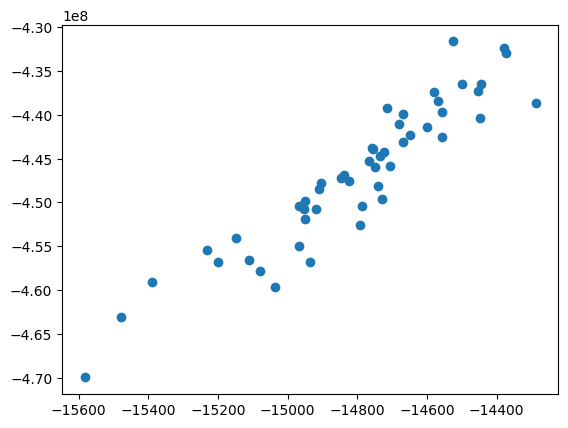

In [23]:
a = []
b = []
for i in range(50):
    test = np.random.normal(size=(sm['coords'].shape[0],)).astype(np.float32)
    a.append(gpd.return_log_prob(
        parameter=test,
        gp_lengthscale=5.0,
        gp_variance=1.0,
        gp_mean=0.0,
        gp_nugget=0.1,
    ))

    b.append(gps.return_log_prob(
        parameter=test,
        gp_lengthscale=0.1,
        gp_variance=1.0,
        gp_mean=0.0,
        gp_nugget=0.1,
    ))
plt.scatter(
    a,b
)

In [ ]:

Q_sparse = build_spde_precision_matrix_matern52(vx, faces, lengthscale, variance, nugget)
logp = compute_log_prob(vertex_values, Q_sparse)

print("Log probability:", logp.numpy())
